# Performance Evaluation of 1D CNN and Fully Connected Neural Networks for Enzyme Function Classification

Description

This notebook presents the implementation and evaluation of two neural network architectures—a 1D Convolutional Neural Network (CNN) and a Fully Connected Neural Network (FCNN)—for the classification of enzyme functions based on embedded amino acid sequences.

The dataset comprises labeled entries representing different enzyme classes, with features extracted through embeddings.

This analysis highlights the importance of addressing class imbalance and improving model performance through various strategies, including data augmentation.

In [2]:
#Data preprocessing and visualisation
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


#Imports needed to run ESM-2

import tensorflow
import torch
import esm

import collections # for creating a default dictionary
import time # for runtimes

#For vectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Supress cell warnings
import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load the data
file_path = '/content/drive/My Drive/updated_500_random_sequences.csv'
data = pd.read_csv(file_path, sep=',')

In [5]:
data.head()

,ID,Entry,Entry Name,Protein names,Organism,Length,Sequence,EC number
0,sp|Q5TM22|TNFC_MACMU,Q5TM22,TNFC_MACMU,Lymphotoxin-beta (LT-beta) (Tumor necrosis fac...,Macaca mulatta (Rhesus macaque),244,MGALGLEGRGGRLQGRGSLLLAVAGATSLVTLLLAVPITVLAVLAL...,0.0.0.0
1,sp|C3MY94|RL24E_SULIM,C3MZM3,RL24E_SULIA,Large ribosomal subunit protein eL24 (50S ribo...,Sulfolobus islandicus (strain M.16.27),61,MPTTRQCSFCGHEIPPGTGLMYVRNDGTMLWFCSSKCRKSMLKYHR...,0.0.0.0
2,sp|Q55486|SYR_SYNY3,Q55486,SYR_SYNY3,Arginine--tRNA ligase (EC 6.1.1.19) (Arginyl-t...,Synechocystis sp. (strain PCC 6803 / Kazusa),584,MVSILTQLNDHFAQALEGQFPSDVTLPTPLVVPASNPKFGDFQCNI...,6.1.1.19
3,sp|O29537|CBIX_ARCFU,O29537,CBIX_ARCFU,Sirohydrochlorin cobaltochelatase (EC 4.99.1.3...,Archaeoglobus fulgidus (strain ATCC 49558 / DS...,132,MRRGLVIVGHGSQLNHYREVMELHRKRIEESGAFDEVKIAFAARKR...,4.99.1.3
4,sp|L0MXJ1|FC3_PHOAM,L0MXJ1,FC3_PHOAM,Fusicoccadiene 8-ol C-16-hydroxylase (EC 1.1.1...,Phomopsis amygdali (Fusicoccum amygdali),526,MIGVCGFQWSLSFSTMYTVSLPHGPFLGSRAQEAFVGFSVLGLTLL...,1.1.1.-


## Data exploration

In [6]:
#Check for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             500 non-null    object
 1   Entry          500 non-null    object
 2   Entry Name     500 non-null    object
 3   Protein names  500 non-null    object
 4   Organism       500 non-null    object
 5   Length         500 non-null    int64 
 6   Sequence       500 non-null    object
 7   EC number      500 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.4+ KB


In [40]:
data.shape

(500, 8)

In [7]:
# Count the number of duplicate rows
duplicate_rows = data.duplicated().sum()

# Print the count of duplicate rows
print(duplicate_rows)

0


**Observations**

Dataset consists of **500** and  sequences and **8** columns in total.

There are no duplicates in our data  


What is the distribution of lenght of the sequences in our data. This is important because it will affect training

In [8]:
data['Length'] = pd.to_numeric(data['Length'], errors='coerce')

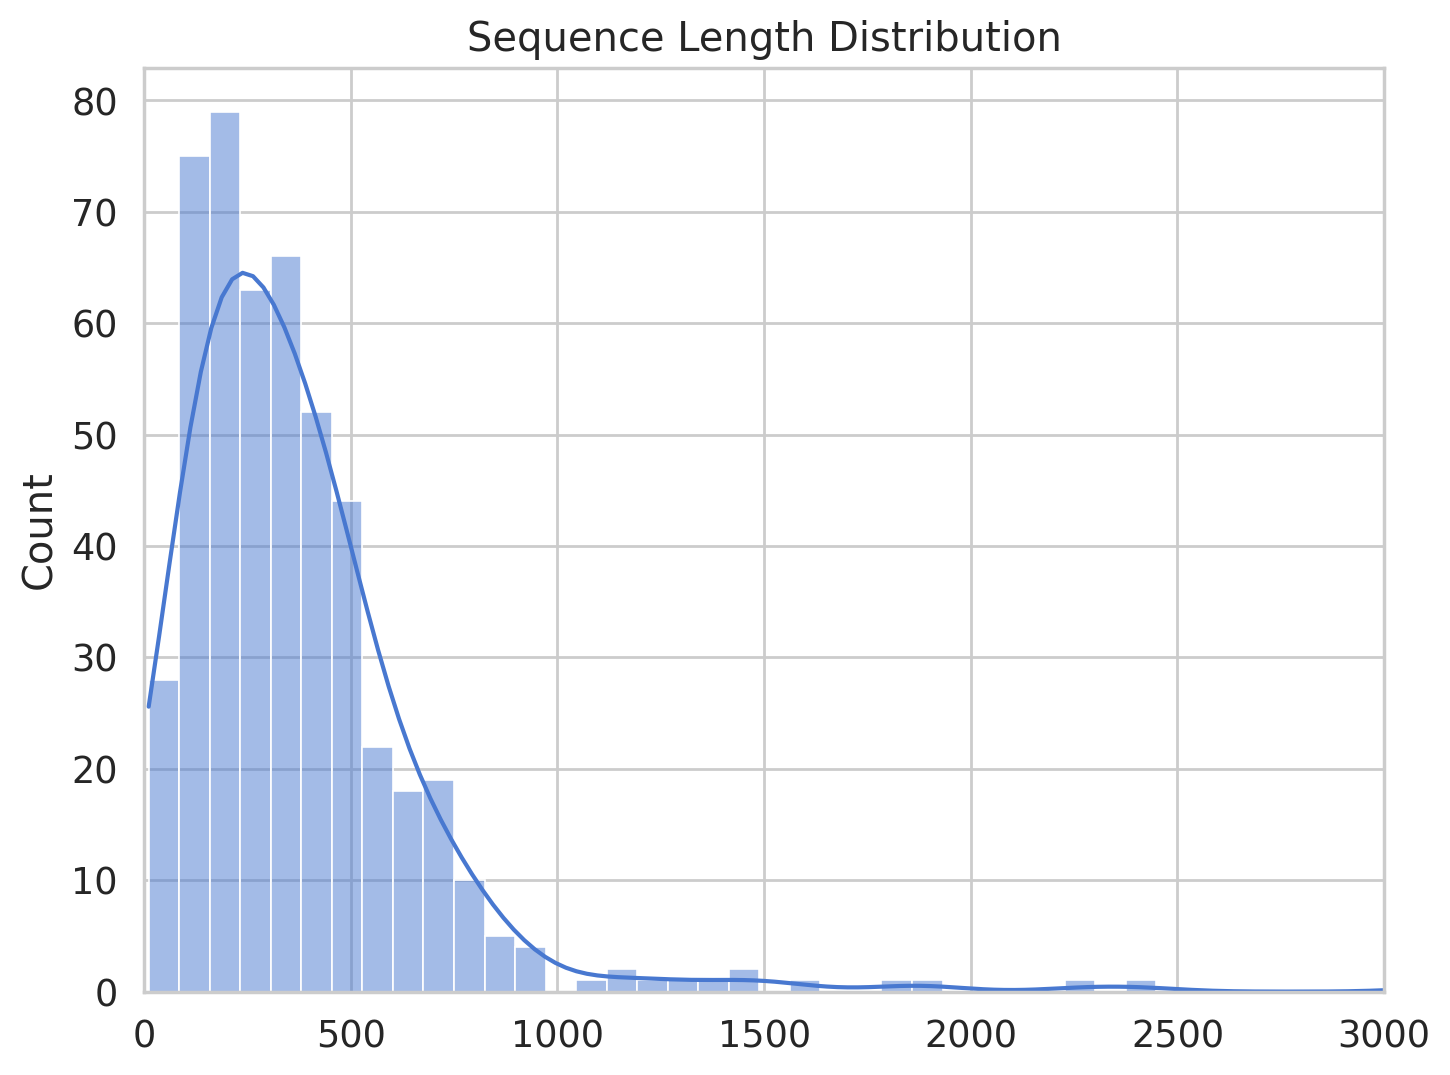

In [58]:
#Check the distribution of sequence length

%config InlineBackend.figure_format='retina'


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# Set the figure size (width, height) in inches
plt.figure(figsize=(8, 6))  # Adjust width and height as needed
ax = sns.histplot(data['Length'].values, kde=True)  # Using histplot instead of distplot
ax.set_xlim(0, 3000)
plt.title('Sequence Length Distribution')
plt.grid(True)
plt.show()


## Filtering out uncommon amino acids and filtering the data by length

In [10]:
data["Length"].describe(percentiles = [.25, .5, .75, .9, .95])

,Length
count,500.000000
mean,380.972000
std,373.650409
min,11.000000
25%,178.750000
50%,313.500000
75%,475.000000
90%,681.200000
95%,815.350000
max,5034.000000


More than 90% of our data have a sequence length of 700 amino acids

In [11]:
#Filtering to only include valid amino acids and a cetirn length

valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY") #Order does not matter

# Filter out rows where the length of the sequence is more than 700

MAX_LENGTH = 700
data_filtered_length = data[data['Sequence'].apply(len) <= MAX_LENGTH]

# Function to check for invalid amino acids
def contains_invalid_amino_acids(seq):
    return any(aa not in valid_amino_acids for aa in seq)

# Filter out rows with invalid amino acids
data_filtered = data_filtered_length[~data_filtered_length['Sequence'].apply(contains_invalid_amino_acids)]

# The resulting filtered DataFrame is stored in 'data_filtered'
#print(data_filtered)

data_filtered

,ID,Entry,Entry Name,Protein names,Organism,Length,Sequence,EC number
0,sp|Q5TM22|TNFC_MACMU,Q5TM22,TNFC_MACMU,Lymphotoxin-beta (LT-beta) (Tumor necrosis fac...,Macaca mulatta (Rhesus macaque),244,MGALGLEGRGGRLQGRGSLLLAVAGATSLVTLLLAVPITVLAVLAL...,0.0.0.0
1,sp|C3MY94|RL24E_SULIM,C3MZM3,RL24E_SULIA,Large ribosomal subunit protein eL24 (50S ribo...,Sulfolobus islandicus (strain M.16.27),61,MPTTRQCSFCGHEIPPGTGLMYVRNDGTMLWFCSSKCRKSMLKYHR...,0.0.0.0
2,sp|Q55486|SYR_SYNY3,Q55486,SYR_SYNY3,Arginine--tRNA ligase (EC 6.1.1.19) (Arginyl-t...,Synechocystis sp. (strain PCC 6803 / Kazusa),584,MVSILTQLNDHFAQALEGQFPSDVTLPTPLVVPASNPKFGDFQCNI...,6.1.1.19
3,sp|O29537|CBIX_ARCFU,O29537,CBIX_ARCFU,Sirohydrochlorin cobaltochelatase (EC 4.99.1.3...,Archaeoglobus fulgidus (strain ATCC 49558 / DS...,132,MRRGLVIVGHGSQLNHYREVMELHRKRIEESGAFDEVKIAFAARKR...,4.99.1.3
4,sp|L0MXJ1|FC3_PHOAM,L0MXJ1,FC3_PHOAM,Fusicoccadiene 8-ol C-16-hydroxylase (EC 1.1.1...,Phomopsis amygdali (Fusicoccum amygdali),526,MIGVCGFQWSLSFSTMYTVSLPHGPFLGSRAQEAFVGFSVLGLTLL...,1.1.1.-
...,...,...,...,...,...,...,...,...
494,sp|Q72AQ6|PHNC_DESVH,Q72AQ6,PHNC_DESVH,Phosphonates import ATP-binding protein PhnC (...,Desulfovibrio vulgaris (strain ATCC 29579 / DS...,265,MSHASDPKKAGAHGDKSLVVEHLRKEYVRGKAVLKDISFTVSGQST...,7.3.2.2
495,sp|B0RRH2|RL20_XANCB,Q8P7Z4,RL20_XANCP,Large ribosomal subunit protein bL20 (50S ribo...,Xanthomonas campestris pv. campestris (strain ...,119,MARVKRGVQARRRHKKILTLAKGYYNARRKVFRVAKQAVIKAQQYA...,0.0.0.0
496,sp|P05654|PYRB_BACSU,P05654,PYRB_BACSU,Aspartate carbamoyltransferase catalytic subun...,Bacillus subtilis (strain 168),304,MKHLTTMSELSTEEIKDLLQTAQELKSGKTDNQLTGKFAANLFFEP...,2.1.3.2
497,sp|B5ZB51|RL24_UREU1,B5ZB51,RL24_UREU1,Large ribosomal subunit protein uL24 (50S ribo...,Ureaplasma urealyticum serovar 10 (strain ATCC...,110,MNRIKKGDTVVVISGKNKNKSGVVIQVNPKEQTALVEGVNKIKRHQ...,0.0.0.0


In [12]:
data_filtered['Length'].max()

697

Visualise the distribution of the target variable per main enzyme class in our filtered data


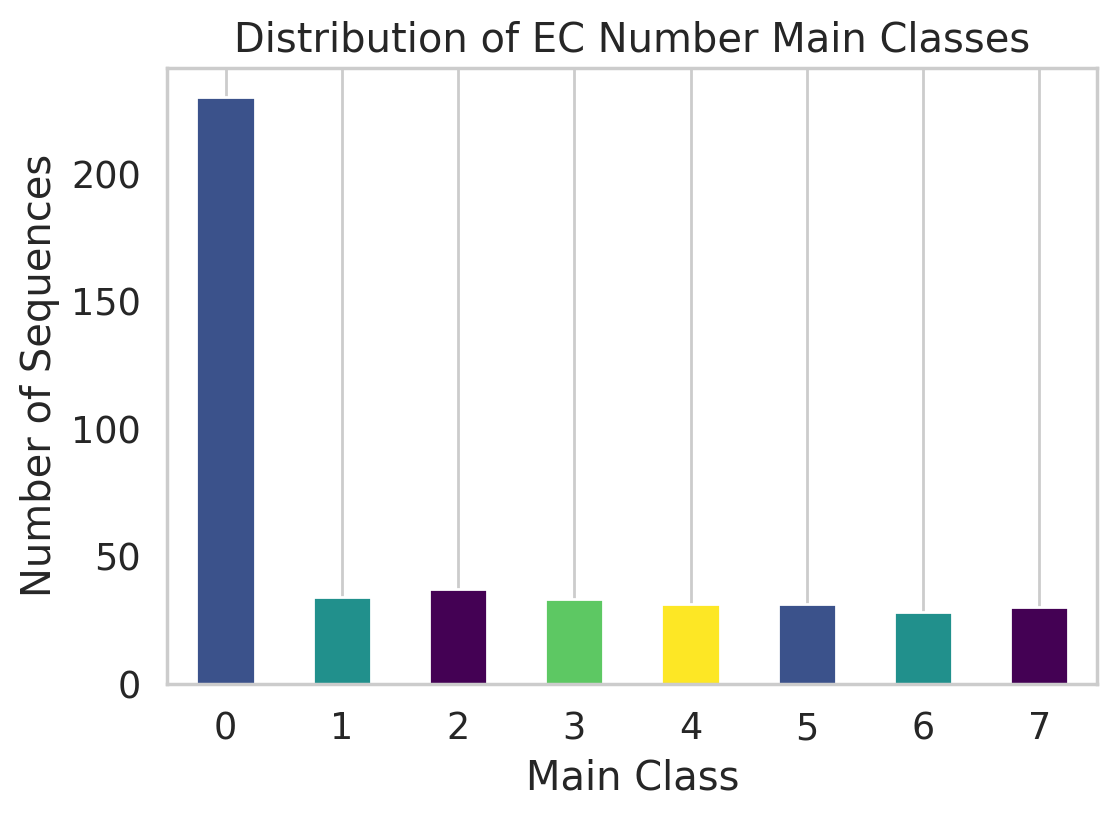

In [59]:
# Step 1: Extract the main class (the first digit)
data_filtered['Main Class'] = data_filtered['EC number'].str.split('.').str[0]

# Step 2: Count occurrences of each main class and sort in descending order
main_class_counts = data_filtered['Main Class'].value_counts().sort_index(ascending=True)

# Define colors for each class (0 to 7)
colors = ['#3B528B','#21908C','#440154','#5DC863', '#FDE725']

# Step 3: Plot the distribution
plt.figure(figsize=(6, 4))
main_class_counts.plot(kind='bar', color=colors[:len(main_class_counts)])  # Use colors for the classes
plt.title('Distribution of EC Number Main Classes')
plt.xlabel('Main Class')
plt.ylabel('Number of Sequences')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
print(main_class_counts)

In [15]:
from sklearn.model_selection import train_test_split

# Split into training and test sets (80% train, 20% test)
X_train_, X_test, y_train_, y_test = train_test_split(
    data_filtered.drop(columns=['EC number'], axis=1),
    data_filtered[['EC number']],
    test_size=0.3,
    shuffle=True,
    random_state=42
)

# Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_,
    y_train_,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

# Combine the splits back into DataFrames

train_df = pd.concat([X_train, y_train], axis='columns').reset_index(drop=True)
valid_df = pd.concat([X_valid, y_valid], axis='columns').reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis='columns').reset_index(drop=True)

# Example: To check the shapes of the splits
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (253, 9)
Validation set shape: (64, 9)
Test set shape: (137, 9)


In [16]:
train_df.head()

,ID,Entry,Entry Name,Protein names,Organism,Length,Sequence,Main Class,EC number
0,sp|Q5ZLL5|COQ5_CHICK,Q5ZLL5,COQ5_CHICK,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...",Gallus gallus (Chicken),311,MAAGLCPGRALLSRRGGALWALLGTARGRAAGPETHFGFQNVSEAE...,2,2.1.1.201
1,sp|Q57484|Y867_HAEIN,Q57484,Y867_HAEIN,Uncharacterized membrane protein HI_0867,Haemophilus influenzae (strain ATCC 51907 / DS...,404,MSLIKDSSIYLIGELSAKCVPFLLLPYLSRKLGVEGFGELSYYQTF...,0,0.0.0.0
2,sp|P15125|RL5A_XENLA,P15125,RL5A_XENLA,Large ribosomal subunit protein uL18A (60S rib...,Xenopus laevis (African clawed frog),296,MGFVKVVKNKAYFKRYQVKFRRRREGKTDYYARKRLVIQDKNKYNT...,0,0.0.0.0
3,sp|Q1ISC7|RS12_KORVE,Q1ISC7,RS12_KORVE,Small ribosomal subunit protein uS12 (30S ribo...,Koribacter versatilis (strain Ellin345),124,MPTFNQLVRKGRTAPKFKTASPALQSCPQKRGVCTRVYTQTPKKPN...,0,0.0.0.0
4,sp|P18356|POLG_DEN2U,P18356,POLG_DEN2U,Genome polyprotein [Cleaved into: Protein prM;...,Dengue virus type 2 (strain Thailand/PUO-218/1...,679,SAGMIIMLIPTVMAFHLTTRNGEPHMIVSRQEKGKSLLFKTEDGVN...,0,0.0.0.0


For our training, we only need the Entry, Length, Sequence and the EC number

In [17]:
train_df.drop(columns=['ID',  'Entry Name', 'Protein names', 'Organism'], axis=1)
valid_df.drop(columns=['ID', 'Entry Name', 'Protein names', 'Organism'], axis=1)
test_df.drop(columns=['ID', 'Entry Name', 'Protein names', 'Organism'], axis=1)

,Entry,Length,Sequence,Main Class,EC number
0,P34614,159,MNPKIEDSEFNWENEDIVMKLVDEKGKAHPVSKAELLESLESRKLG...,0,0.0.0.0
1,P84271,21,GLLASLGKVLGGYLAEKLKPK,0,0.0.0.0
2,O60830,172,MEEYAREPCPWRIVDDCGGAFTMGVIGGGVFQAIKGFRNAPVGIRH...,0,0.0.0.0
3,B4RBX4,337,MSDAFKPLLSRLADGATLSDDDADAFFSACLRGEPTPAQVGAALTA...,2,2.4.2.18
4,A4WEV0,431,MKHLIEMVESHKQGAENGIYAVCSAHPLVLEAAIRFARTHNAALLI...,0,0.0.0.0
...,...,...,...,...,...
132,Q8HXW2,674,MAAAKVALTKRADPAELRTIFLKYASIEKNGEFFTSPNDFVTRYLN...,0,0.0.0.0
133,Q9CWR1,371,MELAEDWLVESLRLYQDFHAFDLSGATRVLEWIGEKGVFVAGYESL...,0,0.0.0.0
134,P15615,387,MEETTDFLFFNKYSREFSYHFFGKFFFFKEINTKLIFFFERFNLFS...,0,0.0.0.0
135,Q3TC72,313,MLGFGRRRLFSALLQVQKRPCQPSRNMRLVQFQAPHLEEPHLGLES...,3,3.-.-.-


In [18]:
#Save dataframes

train_df.to_csv("Train.csv", index=False)

valid_df.to_csv("Valid.csv", index=False)

test_df.to_csv("Test.csv", index=False)


# Vectorization


## Converting amino acid sequence data to numerical representations

### ESM-2 (Evolutionary Scaled Model)

ESM-2 is a transformer-based
language model, that uses attention mechanism to learn patterns in amino acid sequences

It provides numerical embeddings for each amino acid in a protein sequence


ESM-2 was trained on the UniRef50 dataset (UniProt Reference Clusters, 50% threshold)


### esm_embeddings Function

This function loads the ESM-2 model. Converts sequences into batch tokens, generates embeddings for a batch of sequences, averages token representations to get a single embedding per sequence and then converts the embendings into a dataframe.

In [19]:
def esm_embeddings(peptide_sequence_list):

    # Load the pre-trained ESM model and alphabet
    model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval() # means don't learn anything new from the data just be a predictor

    # Convert sequences to batch tokens - a format that the model understands
    # Each token represents a specific part of the amino acid sequence

    _, _, batch_tokens = batch_converter(peptide_sequence_list)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Here we use the ESM model to process the batch tokens and generate representations (or embeddings) for each aa in a sequence
    # These representations capture the important features and patterns in the sequences

    with torch.no_grad(): #emphasising on dont train again/dont change parameters/gradient
        results = model(batch_tokens, repr_layers=[6], return_contacts=True) #6 layers, capture the info in the 6th layers,model learns deeper as er go up the layers
    token_representations = results["representations"][6]

    # After obtaining the representations, we further refine them by averaging the token representations
    # This means we combine the information from all tokens in a sequence to get a single, concise representation of the entire sequence

    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1:tokens_len - 1].mean(0))

    # Save dataset
    embeddings_results = collections.defaultdict(list)
    for i, seq_rep in enumerate(sequence_representations):
        embeddings_results[i] = seq_rep.tolist()

    # Convert to DataFrame
    embeddings_results_df = pd.DataFrame.from_dict(embeddings_results, orient='index')
    return embeddings_results_df



This function manages the processing of individual sequences one at a time, tracks the time it takes to process each sequence and then call esm_embeddings to handle the actual embedding generation for each sequence

In [20]:
def esm_embedding_data(sequence):
    # Record processing times
    times = []
    sequence_list = sequence
    embeddings_results = pd.DataFrame()

    for seq in sequence_list:
        start_time = time.time()

        # Format sequence input for ESM model
        formatted_seq = [(seq, seq)] # thats the format required for attention. You have give it information about the position and the sequence, indexing the seq by iteslf

        # Get embeddings for the sequence
        one_seq_embeddings = esm_embeddings(formatted_seq)

        # Concatenate the results
        embeddings_results = pd.concat([embeddings_results, one_seq_embeddings]) #append the result to df

        end_time = time.time()
        times.append(end_time - start_time)

    # Print average processing time
    if times:
        average_time = sum(times) / len(times)
        print(f"--->Average processing time per sequence: {average_time:.4f} seconds")

    return embeddings_results #return the dataframe for all the sequences


**Now you want to call the embeddings function on your data:**

In [21]:
print(f'Start: ESM Embedding for Dataset')

# Apply ESM embeddings to the dataset
embeddings_train_data = esm_embedding_data(train_df['Sequence'])

print(f'End: ESM Embedding for Dataset\n')


Start: ESM Embedding for Dataset


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


--->Average processing time per sequence: 0.5335 seconds
End: ESM Embedding for Dataset



In [23]:
print(f'Start: ESM Embedding for Dataset')

# Apply ESM embeddings to the dataset
embeddings_test_data = esm_embedding_data(test_df['Sequence'])

print(f'End: ESM Embedding for Dataset\n')


Start: ESM Embedding for Dataset
--->Average processing time per sequence: 0.5170 seconds
End: ESM Embedding for Dataset



In [24]:
print(f'Start: ESM Embedding for Dataset')

# Apply ESM embeddings to the dataset
embeddings_valid_data = esm_embedding_data(valid_df['Sequence'])

print(f'End: ESM Embedding for Dataset\n')


Start: ESM Embedding for Dataset
--->Average processing time per sequence: 0.5624 seconds
End: ESM Embedding for Dataset



In [29]:
embeddings_valid_data

,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,-0.059494,-0.245017,-0.032974,0.122724,0.126021,-0.061433,0.021978,0.031949,-0.032659,0.135043,...,0.186258,-0.048756,0.173493,-0.009292,-0.426887,-0.123426,0.071869,0.212900,0.098992,-0.003237
0,-0.327955,-0.480325,0.015883,0.052800,0.061499,-0.108157,0.031668,0.187706,0.336671,-0.001186,...,0.162507,-0.111665,0.052654,0.253987,-0.044120,0.296778,-0.184337,0.417789,-0.294625,-0.174899
0,-0.136279,-0.100435,0.186142,0.136284,0.128336,0.047190,-0.014572,-0.047356,-0.014789,-0.108897,...,0.056810,0.090377,0.018728,0.093092,0.065446,-0.172378,-0.124075,0.157227,0.074799,0.001052
0,-0.019166,-0.118514,0.127553,0.027212,0.072185,-0.019317,0.007395,-0.045863,0.114156,-0.065170,...,-0.005501,0.045445,-0.020357,0.087549,0.106545,-0.181431,-0.064212,0.264479,-0.096392,-0.069805
0,-0.164499,-0.087475,0.188067,0.182709,0.104530,-0.008229,-0.054585,-0.033603,-0.136757,-0.096699,...,0.039133,0.065959,-0.001208,0.036427,0.089059,-0.201256,-0.151406,0.153518,0.050248,-0.007015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.055482,-0.004991,0.262871,0.207823,0.090606,-0.022246,0.065194,-0.212325,-0.117173,-0.126469,...,-0.044074,-0.092760,-0.001768,0.197921,0.068995,-0.101782,0.072727,0.316040,0.173837,0.036121
0,-0.025401,-0.114221,-0.054578,-0.008521,0.402288,-0.214864,0.074305,-0.080021,-0.174945,-0.118821,...,0.101719,-0.388805,-0.103870,0.126220,-0.024739,-0.218225,0.048198,0.350775,-0.101838,-0.078931
0,-0.075811,-0.174417,0.110739,0.100745,0.140512,-0.075157,0.014512,0.012666,-0.076843,0.024761,...,0.122764,-0.081022,0.017748,0.138282,-0.043740,-0.000317,0.082068,0.354312,-0.115061,0.019373
0,0.030296,0.000807,0.164285,0.159931,-0.096322,-0.105612,-0.138959,0.037224,-0.160397,-0.033749,...,0.101661,-0.017018,0.135978,0.083335,-0.151102,-0.195759,-0.128515,-0.095892,0.071718,0.193505


In [27]:
import pickle

# Save embeddings
def save_embeddings(embeddings_df, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(embeddings_df, f)

In [28]:
# Assuming you have your embeddings DataFrames ready
save_embeddings(embeddings_train_data, 'train_embeddings.pkl')
save_embeddings(embeddings_test_data, 'test_embeddings.pkl')
save_embeddings(embeddings_valid_data, 'val_embeddings.pkl')

**Interpretation of the embeddings**

Each row in the embeddings matrix represents a protein sequence, and each column represents a dimension of the learned embedding.

If an embedding has 320 dimensions, it means that each embedding vector (i.e a protein sequence in this case) is a 320-dimensional vector

Each dimension within this vector corresponds to a specific feature, which could be:

**Structural features:** Presence of alpha helices, beta sheets, or turns
**Functional features:** Active sites, binding regions, or domains
**Evolutionary features:** Conservation patterns across species

Basically in this case 320 features for each protein sequence

### Evaluation of the embeddings

How do we know that our embeddings are good?

**Dimensionality reduction could be used**

**Steps to Apply Dimensionality Reduction:**

Normalise Embeddings: Ensure embeddings are normalized or standardized before applying dimensionality reduction techniques to avoid bias towards certain dimensions.

Choose Technique: Select an appropriate technique based on your data and goals (e.g., PCA for linear dimensionality reduction, t-SNE for nonlinear visualisation).

Plot Results: Visualise the reduced-dimensional embeddings and analyse the patterns or clusters that emerg

# Dimentionality reduction with TSne

In [ ]:
""" #Load embeddings
def load_embeddings(file_name):
    with open(file_name, 'rb') as f:
        embeddings_df = pickle.load(f)
    return embeddings_df"""

In [ ]:
"""# Later, when you want to reload the embeddings
train_embeddings = load_embeddings('train_embeddings.pkl')
test_embeddings = load_embeddings('test_embeddings.pkl')
val_embeddings = load_embeddings('val_embeddings.pkl')"""

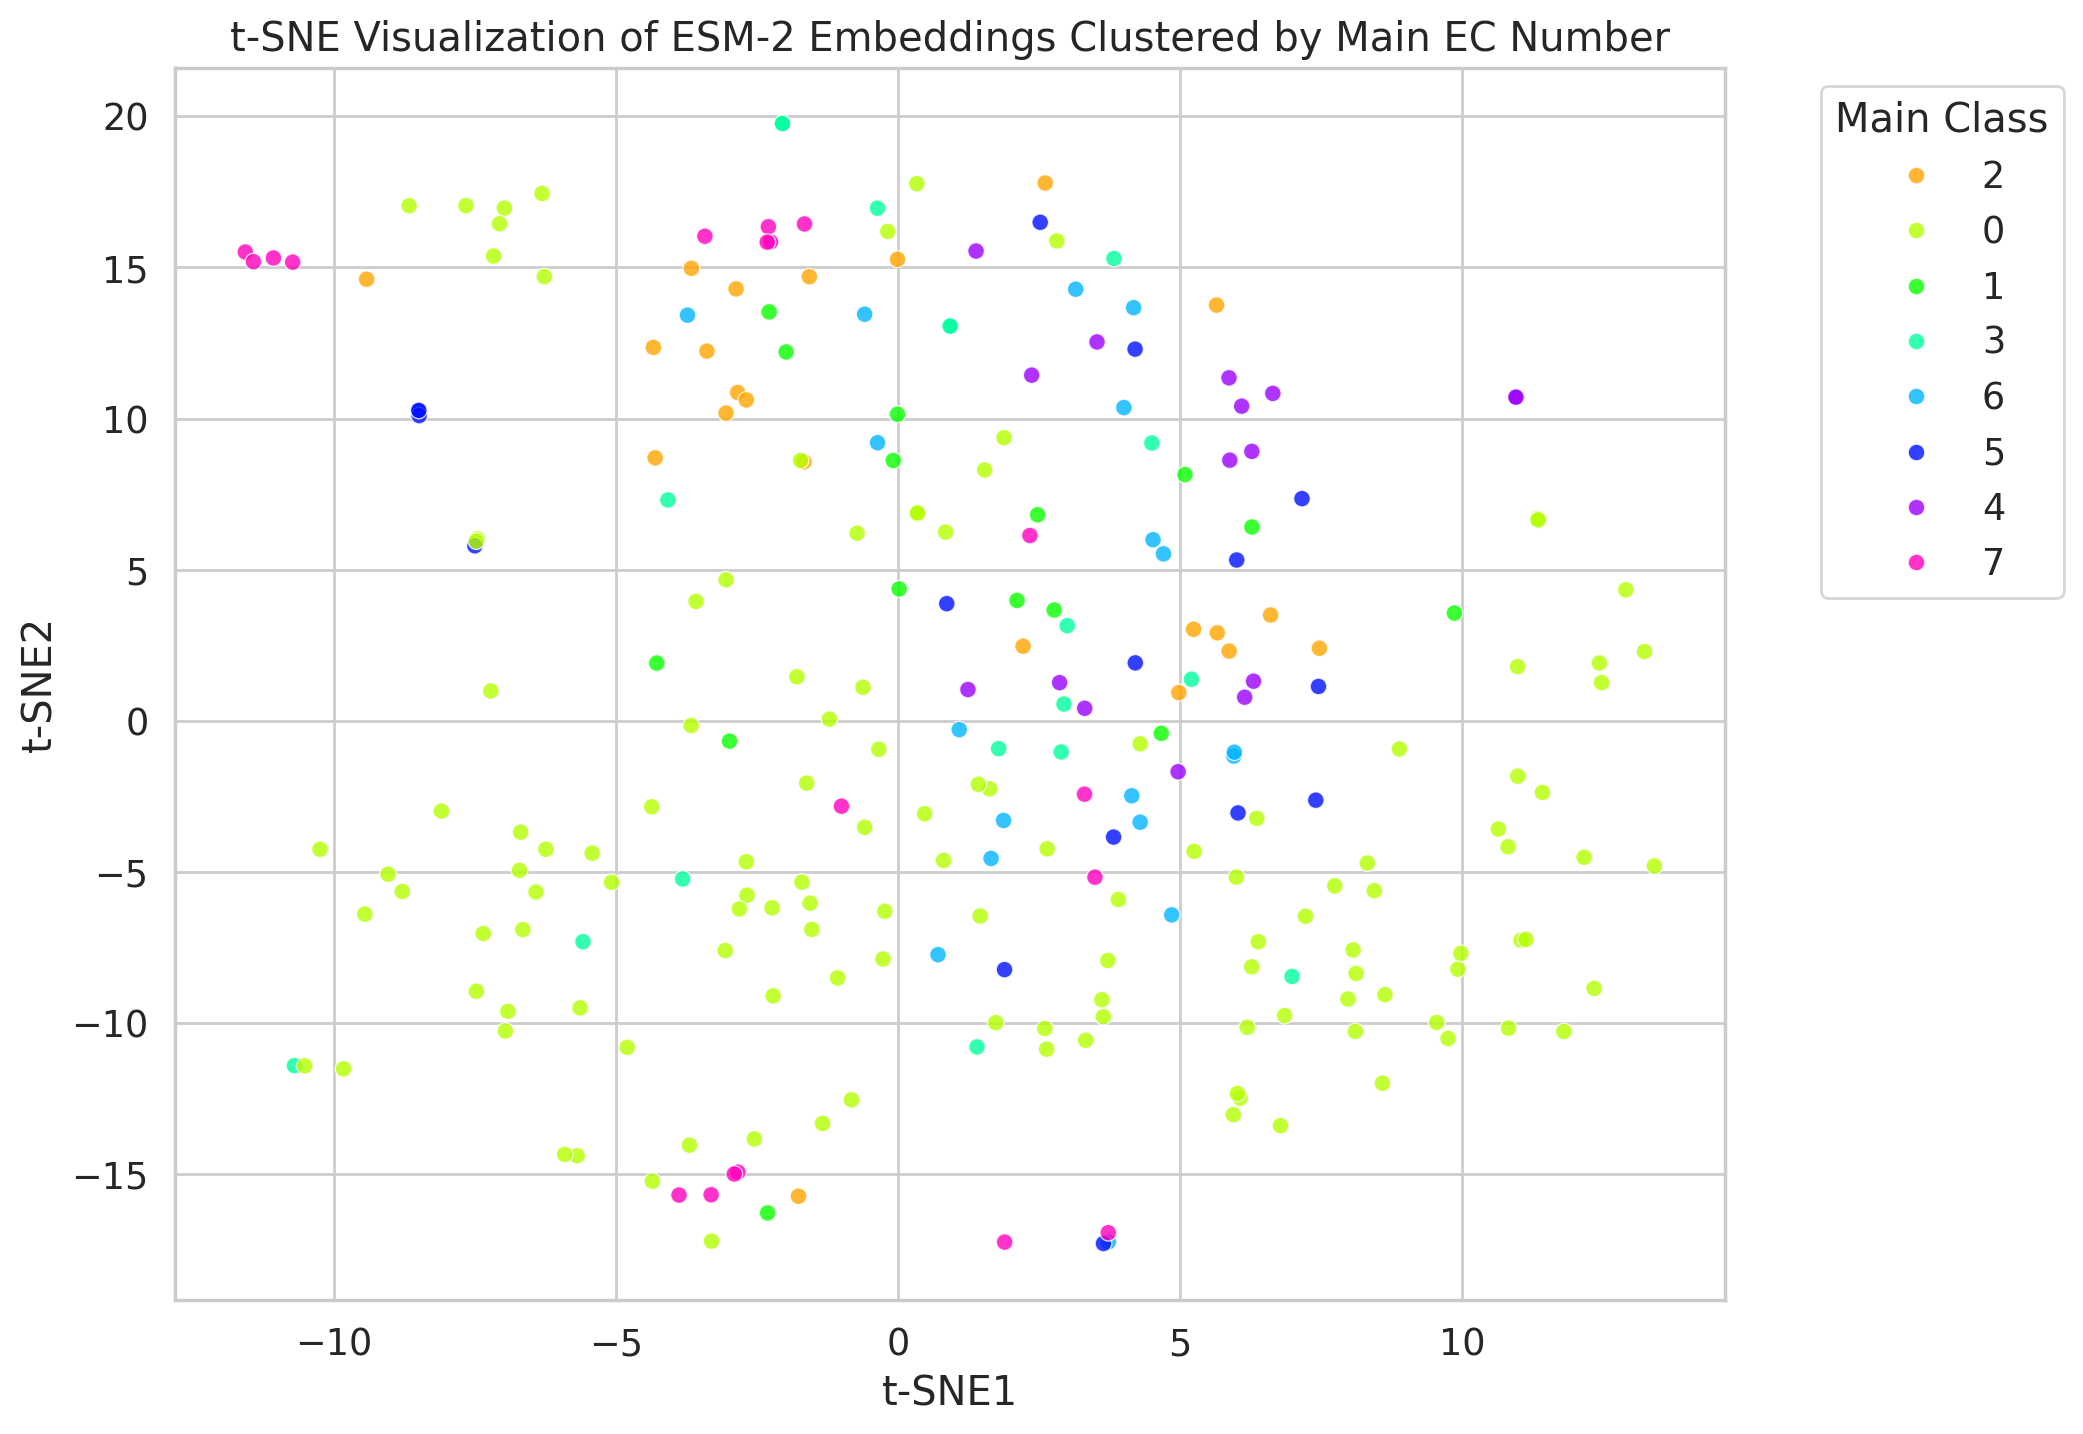

In [35]:
from sklearn.manifold import TSNE

# Step 1: Extract the embeddings and the labels (Main Class)
embeddings = embeddings_train_data.values  # Assuming this is your embeddings DataFrame
main_classes = train_df['Main Class']


# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Step 3: Create a new DataFrame with the t-SNE results and the Main Class
tsne_df = train_df[['Main Class']].copy()
tsne_df['t-SNE1'] = tsne_results[:, 0]
tsne_df['t-SNE2'] = tsne_results[:, 1]

# Step 4: Define a custom color palette (one color for each class)
num_classes = len(tsne_df['Main Class'].unique())
palette = sns.color_palette("hsv", num_classes)  # Using HSV palette to assign distinct colors

# Step 5: Plot the t-SNE results with different colors for each Main Class
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='t-SNE1', y='t-SNE2',
    hue='Main Class',
    palette=palette,  # Assign custom palette
    data=tsne_df,
    legend="full",
    alpha=0.8
)

plt.title('t-SNE Visualization of ESM-2 Embeddings Clustered by Main EC Number')
plt.legend(title='Main Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Dimentionality reduction with UMAP

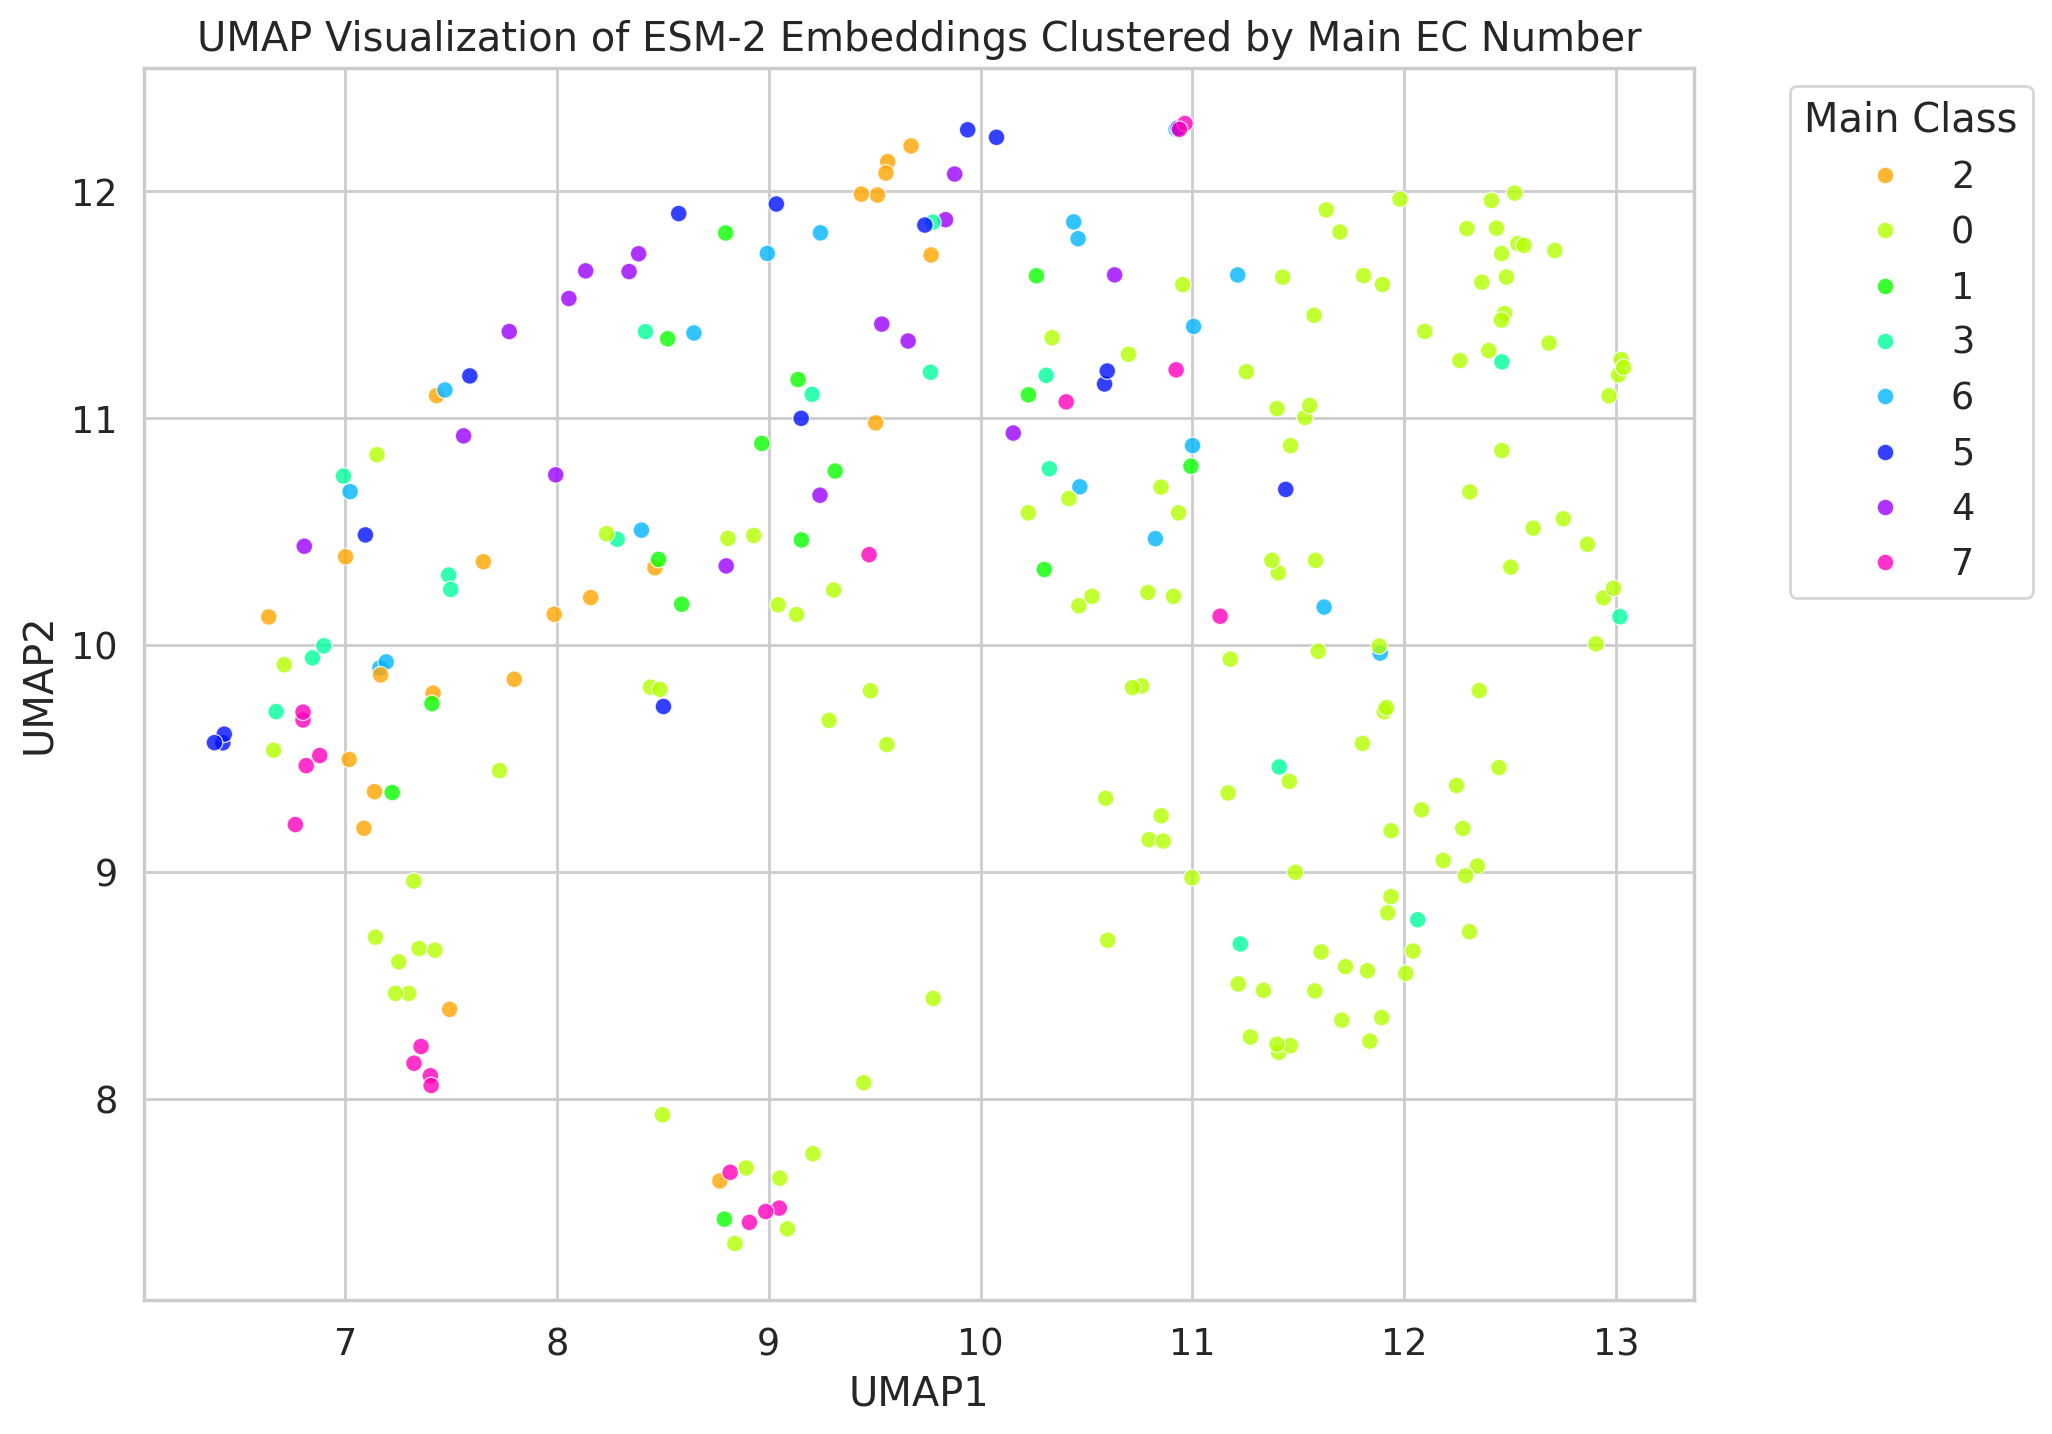

In [38]:
import umap  # Import UMAP

# Step 1: Extract the embeddings and the labels (Main Class)
embeddings = embeddings_train_data.values  # Assuming this is your embeddings DataFrame
main_classes = train_df['Main Class']  # Assuming this is your original DataFrame with EC classes

# Step 2: Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(embeddings)

# Step 3: Create a new DataFrame with the UMAP results and the Main Class
umap_df = train_df[['Main Class']].copy()
umap_df['UMAP1'] = umap_results[:, 0]
umap_df['UMAP2'] = umap_results[:, 1]

# Step 4: Define a custom color palette (one color for each class)
num_classes = len(umap_df['Main Class'].unique())
palette = sns.color_palette("hsv", num_classes)  # Using HSV palette to assign distinct colors

# Step 5: Plot the UMAP results with different colors for each Main Class
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Main Class',
    palette=palette,  # Assign custom palette
    data=umap_df,
    legend="full",
    alpha=0.8
)

plt.title('UMAP Visualization of ESM-2 Embeddings Clustered by Main EC Number')
plt.legend(title='Main Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

With bigger dataset, the goal would be to see disctinct clustering of the different classes.

## Modelling

Combine the metadata with embeddings

In [40]:
print(train_df.shape, embeddings_train_data.shape)


(253, 9) (253, 320)


In [42]:
# Reset index for both DataFrames to ensure they align
train_df.reset_index(drop=True, inplace=True)
embeddings_train_data.reset_index(drop=True, inplace=True)

# Step 2: Concatenate the DataFrames along axis 1
train_with_embeddings = pd.concat([train_df[['Entry', 'Main Class', 'EC number']], embeddings_train_data], axis=1)


In [44]:
test_df.reset_index(drop=True, inplace=True)
embeddings_test_data.reset_index(drop=True, inplace=True)

test_with_embeddings = pd.concat([test_df[['Entry', 'Main Class', 'EC number']], embeddings_test_data], axis=1)


In [45]:
valid_df.reset_index(drop=True, inplace=True)
embeddings_valid_data.reset_index(drop=True, inplace=True)

valid_with_embeddings = pd.concat([valid_df[['Entry', 'Main Class', 'EC number']], embeddings_valid_data], axis=1)


In [43]:
train_with_embeddings

,Entry,Main Class,EC number,0,1,2,3,4,5,6,...,310,311,312,313,314,315,316,317,318,319
0,Q5ZLL5,2,2.1.1.201,-0.038782,-0.110199,0.156641,0.089688,0.069552,-0.224213,0.047997,...,0.014247,-0.137078,0.007652,-0.005197,-0.060254,-0.053519,-0.088356,0.385297,-0.187334,-0.075193
1,Q57484,0,0.0.0.0,-0.167285,0.253734,0.428914,0.310114,0.199141,-0.028376,0.210985,...,-0.127808,0.066360,-0.085824,-0.118294,0.065334,-0.034000,-0.177091,0.085161,-0.130297,0.385401
2,P15125,0,0.0.0.0,-0.164249,-0.005249,0.131316,0.361251,0.191759,-0.033646,0.010885,...,-0.018152,0.116176,-0.081723,-0.055346,0.100814,-0.205107,-0.076169,0.068241,0.016894,-0.020119
3,Q1ISC7,0,0.0.0.0,-0.112797,-0.056830,0.263092,0.292486,0.053380,-0.170008,-0.113607,...,0.126342,0.025680,0.042223,0.070064,0.021308,-0.227376,-0.067360,0.254640,0.045410,-0.052125
4,P18356,0,0.0.0.0,-0.004507,0.065055,-0.011080,0.085699,0.006832,-0.083648,-0.001867,...,0.167455,0.122941,-0.164818,0.124577,0.005975,-0.042200,-0.106844,-0.136640,0.071537,0.103962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,P11650,5,5.5.1.6,-0.056249,-0.030240,0.063098,0.128632,0.166306,0.081557,0.069248,...,0.073248,0.092676,-0.068292,0.109495,0.049461,-0.194671,-0.093498,0.130537,-0.000488,0.071079
249,Q48E54,0,0.0.0.0,-0.187152,-0.075224,0.162247,0.198122,0.127828,-0.008422,-0.049016,...,0.036190,0.087307,-0.010241,0.030562,0.073984,-0.214751,-0.150171,0.161744,0.038081,-0.005744
250,A0KJH4,3,3.5.4.5,-0.098122,-0.034823,0.144472,-0.150714,0.075548,0.180431,0.047769,...,-0.102809,0.012348,-0.049841,0.108183,-0.071342,-0.198024,-0.234293,0.189212,0.058437,-0.087181
251,Q5F3J5,0,0.0.0.0,-0.013911,-0.170776,0.067352,0.107952,0.024908,-0.102714,-0.056709,...,0.179745,-0.049838,0.051270,0.129055,0.210891,0.002402,0.029103,0.133715,-0.121500,0.064590


### 1D CNN model

We will be using the embeddings as input and main ec number prediction as target

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# Step 1: Extract embeddings and labels
X_train = train_with_embeddings.iloc[:, 3:].values  # Embedding features (from column 3 onwards)
y_train = train_with_embeddings['Main Class'].values  # Target labels

# Step 2: Convert labels to categorical (one-hot encoding)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit and transform the labels
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)  # One-hot encoding

# Step 3: Reshape X_train for CNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Add a channel dimension

# Step 4: Build the 1D CNN model
model = models.Sequential()

# Add a 1D convolutional layer
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a pooling layer
model.add(layers.MaxPooling1D(pool_size=2))

# Add more convolutional and pooling layers if necessary
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output
model.add(layers.Flatten())

# Add a dense layer
model.add(layers.Dense(64, activation='relu'))

# Add the output layer (number of classes)
model.add(layers.Dense(y_train_categorical.shape[1], activation='softmax'))

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Prepare validation data
X_valid = valid_with_embeddings.iloc[:, 3:].values  # Validation embedding features
y_valid = valid_with_embeddings['Main Class'].values  # Validation target labels

# Convert validation labels to categorical
y_valid_encoded = label_encoder.transform(y_valid)  # Use the same label encoder
y_valid_categorical = tf.keras.utils.to_categorical(y_valid_encoded)  # One-hot encoding

# Reshape X_valid for CNN
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)  # Add a channel dimension

# Step 7: Train the model
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32,
                    validation_data=(X_valid, y_valid_categorical),
                    verbose=1)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.4637 - loss: 1.8958 - val_accuracy: 0.5938 - val_loss: 1.4436
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4950 - loss: 1.7091 - val_accuracy: 0.5938 - val_loss: 1.4619
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5230 - loss: 1.5635 - val_accuracy: 0.5938 - val_loss: 1.3920
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5047 - loss: 1.5530 - val_accuracy: 0.5938 - val_loss: 1.3525
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4884 - loss: 1.5259 - val_accuracy: 0.5938 - val_loss: 1.2843
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5120 - loss: 1.4087 - val_accuracy: 0.5938 - val_loss: 1.2050
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5423 - loss: 1.3694 - val_accuracy: 0.6094 - val_loss: 1.1176
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5977 - loss: 1.2199 - val_accuracy: 0.6562 - val_loss: 1.0605
Epoch 

# Evaluate the 1D CNN model

In [51]:
#Prepare the test data
X_test = test_with_embeddings.iloc[:, 3:].values  # Extract embedding features
y_test = test_with_embeddings['Main Class'].values  # Extract target labels

# Convert test labels to categorical using the same label encoder
y_test_encoded = label_encoder.transform(y_test)  # Use the same label encoder
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded)  # One-hot encoding

# Reshape X_test for CNN (samples, timesteps, features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)  # Add a channel dimension

# Step 2: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=1)

# Print the evaluation results
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.6485 - loss: 2.1009
Test Loss: 2.0628
Test Accuracy: 0.6277


### Feedforward Convolutional Neural Network (FCNN)

In [52]:
# No need to reshape for FCNN, just ensure y is in categorical format
y_train_categorical = tf.keras.utils.to_categorical(y_train)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid)
y_test_categorical = tf.keras.utils.to_categorical(y_test)

# Build the FCNN model
model_fcnn = models.Sequential()

# Input layer
model_fcnn.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

# Hidden layers
model_fcnn.add(layers.Dense(128, activation='relu'))
model_fcnn.add(layers.Dense(64, activation='relu'))

# Output layer (number of classes)
model_fcnn.add(layers.Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model_fcnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_fcnn = model_fcnn.fit(X_train, y_train_categorical, epochs=50, batch_size=32,
                               validation_data=(X_valid, y_valid_categorical),
                               verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 564ms/step - accuracy: 0.3634 - loss: 1.8816 - val_accuracy: 0.5938 - val_loss: 1.4604
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5620 - loss: 1.5180 - val_accuracy: 0.5938 - val_loss: 1.3112
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4976 - loss: 1.5261 - val_accuracy: 0.5938 - val_loss: 1.2531
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5094 - loss: 1.4112 - val_accuracy: 0.5938 - val_loss: 1.1958
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5277 - loss: 1.3480 - val_accuracy: 0.6094 - val_loss: 1.1233
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5729 - loss: 1.2240 - val_accuracy: 0.6094 - val_loss: 1.0615
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6365 - loss: 1.1146 - val_accuracy: 0.6250 - val_loss: 1.0160
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6578 - loss: 1.0702 - val_accuracy: 0.6406 - val_loss: 0.9814
Epoc

In [53]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_fcnn.evaluate(X_test, y_test_categorical, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.5544, Test Accuracy: 0.6277


In [56]:
from sklearn.metrics import classification_report

y_test_encoded = label_encoder.transform(y_test)

# For 1D CNN
y_pred_cnn = model.predict(test_with_embeddings.iloc[:, 3:].values.reshape(test_with_embeddings.shape[0], -1, 1))
y_pred_labels_cnn = np.argmax(y_pred_cnn, axis=1)  # Get predicted class labels

# For FCNN
y_pred_fcnn = model_fcnn.predict(test_with_embeddings.iloc[:, 3:].values)
y_pred_labels_fcnn = np.argmax(y_pred_fcnn, axis=1)  # Get predicted class labels

# Generate classification reports
report_cnn = classification_report(y_test_encoded, y_pred_labels_cnn, target_names=label_encoder.classes_)
report_fcnn = classification_report(y_test_encoded, y_pred_labels_fcnn, target_names=label_encoder.classes_)

# Print the reports
print("1D CNN Classification Report:\n", report_cnn)
print("FCNN Classification Report:\n", report_fcnn)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1D CNN Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83        63
           1       0.86      0.40      0.55        15
           2       0.57      0.67      0.62        12
           3       0.14      0.07      0.10        14
           4       0.24      0.40      0.30        10
           5       0.40      0.22      0.29         9
           6       0.50      0.43      0.46         7
           7       0.67      0.86      0.75         7

    accuracy                           0.63       137
   macro avg       0.52      0.49      0.48       137
weighted avg       0.62      0.63      0.61       137

FCNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.85        63
           1       0.67      0.67      0.67        15
           2       0.58      0.58      0.58      

### Interpretation of results

Both models exhibit similar overall accuracy but have varying performance across different classes

The first class (0) is consistently the best predicted class across both models, while other classes show poor prediction capabilities, particularly classes 3, 4, 5, and 6

Next step is to upscale data- the models are not performing well in underepresented classes and also adress the issue of class impalance. The models are biased towards the overrepresented class.